In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('../finaldata.csv', sep=',').set_index('Date')


In [3]:
b=df

In [4]:
b

,T2M,QV2M,PRECTOTCORR,WS10M,Hour_sin,Hour_cos,Day_sin,Day_cos
Date,,,,,,,,
2005-01-02 00:00:00,12.12,5.68,0.0,1.14,0.000000,1.000000,0.034422,0.999407
2005-01-02 01:00:00,11.80,5.62,0.0,1.26,0.258819,0.965926,0.034422,0.999407
2005-01-02 02:00:00,11.32,5.55,0.0,1.40,0.500000,0.866025,0.034422,0.999407
2005-01-02 03:00:00,11.03,5.43,0.0,1.53,0.707107,0.707107,0.034422,0.999407
2005-01-02 04:00:00,10.92,5.31,0.0,1.65,0.866025,0.500000,0.034422,0.999407
...,...,...,...,...,...,...,...,...
2022-11-15 01:00:00,12.45,7.45,0.0,0.76,0.258819,0.965926,0.255353,0.966848
2022-11-15 02:00:00,12.25,7.32,0.0,0.96,0.500000,0.866025,0.255353,0.966848
2022-11-15 03:00:00,11.83,7.20,0.0,1.06,0.707107,0.707107,0.255353,0.966848


In [5]:
n_steps_out=10
n_steps_in= 24
n_features = 8

In [6]:
# split a multivariate sequence into samples
def split_sequences(df, n_steps_in, n_steps_out):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)):
 # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
 # check if we are beyond the dataset
         if out_end_ix > len(df_as_np):
             break
 # gather input and output parts of the pattern
         seq_x, seq_y = df_as_np[i:end_ix, :], df_as_np[end_ix:out_end_ix, :2]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
X, y = split_sequences(b, n_steps_out=10,
n_steps_in= 24)
X.shape, y.shape

((156597, 24, 8), (156597, 10, 2))

In [8]:
print(f'Given X = {X[0].flatten()} \n')
print(f'we predict {y[0].flatten()}')

Given X = [ 1.21200000e+01  5.68000000e+00  0.00000000e+00  1.14000000e+00
  0.00000000e+00  1.00000000e+00  3.44216116e-02  9.99407401e-01
  1.18000000e+01  5.62000000e+00  0.00000000e+00  1.26000000e+00
  2.58819045e-01  9.65925826e-01  3.44216116e-02  9.99407401e-01
  1.13200000e+01  5.55000000e+00  0.00000000e+00  1.40000000e+00
  5.00000000e-01  8.66025404e-01  3.44216116e-02  9.99407401e-01
  1.10300000e+01  5.43000000e+00  0.00000000e+00  1.53000000e+00
  7.07106781e-01  7.07106781e-01  3.44216116e-02  9.99407401e-01
  1.09200000e+01  5.31000000e+00  0.00000000e+00  1.65000000e+00
  8.66025404e-01  5.00000000e-01  3.44216116e-02  9.99407401e-01
  1.10000000e+01  5.25000000e+00  0.00000000e+00  1.69000000e+00
  9.65925826e-01  2.58819045e-01  3.44216116e-02  9.99407401e-01
  1.10500000e+01  5.19000000e+00  0.00000000e+00  1.70000000e+00
  1.00000000e+00  6.12323400e-17  3.44216116e-02  9.99407401e-01
  1.14800000e+01  5.31000000e+00  0.00000000e+00  1.66000000e+00
  9.65925826e-0

In [9]:
X_train, y_train = X[:135000], y[:135000]
X_val, y_val = X[135000:150000], y[135000:150000]
X_test, y_test = X[150000:], y[150000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((135000, 24, 8),
 (135000, 10, 2),
 (15000, 24, 8),
 (15000, 10, 2),
 (6597, 24, 8),
 (6597, 10, 2))

In [10]:
model_enc_gru = Sequential()
model_enc_gru.add(GRU(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_gru.add(RepeatVector(n_steps_out))
model_enc_gru.add(GRU(32, activation='relu', return_sequences=True))
model_enc_gru.add(TimeDistributed(Dense(2)))
model_enc_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14208     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 10, 32)            9408      
                                                                 
 time_distributed (TimeDistr  (None, 10, 2)            66        
 ibuted)                                                         
                                                                 
Total params: 23,682
Trainable params: 23,682
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp_gru = ModelCheckpoint('model_gru', save_best_only=True, monitor='val_loss')
model_enc_gru.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))

In [12]:
history = model_enc_gru.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_gru,EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/200
4219/4219 [==============================] - 90s 20ms/step - loss: 15.3655 - val_loss: 10.9826
Epoch 2/200
4219/4219 [==============================] - 91s 22ms/step - loss: 9.4888 - val_loss: 10.2842
Epoch 3/200
4219/4219 [==============================] - 92s 22ms/step - loss: 8.0126 - val_loss: 9.9181
Epoch 4/200
4219/4219 [==============================] - 88s 21ms/step - loss: 7.1827 - val_loss: 9.8368
Epoch 5/200
4219/4219 [==============================] - 86s 20ms/step - loss: 6.6067 - val_loss: 9.6203
Epoch 6/200
4219/4219 [==============================] - 88s 21ms/step - loss: 6.1421 - val_loss: 9.4931
Epoch 7/200
4219/4219 [==============================] - 79s 19ms/step - loss: 5.8399 - val_loss: 9.2594
Epoch 8/200
4219/4219 [==============================] - 79s 19ms/step - loss: 5.6168 - val_loss: 8.9433
Epoch 9/200
4219/4219 [==============================] - 80s 19ms/step - loss: 5.4448 - val_loss: 8.7150
Epoch 10/200
4219/4219 [============================

4219/4219 [==============================] - 97s 23ms/step - loss: 4.2666 - val_loss: 5.6689
Epoch 38/200
4219/4219 [==============================] - 95s 22ms/step - loss: 4.2520 - val_loss: 5.6343
Epoch 39/200
4219/4219 [==============================] - 103s 24ms/step - loss: 4.2416 - val_loss: 5.5935
Epoch 40/200
4219/4219 [==============================] - 81s 19ms/step - loss: 4.2281 - val_loss: 5.5897
Epoch 41/200
4219/4219 [==============================] - 84s 20ms/step - loss: 4.2173 - val_loss: 5.5549
Epoch 42/200
4219/4219 [==============================] - 85s 20ms/step - loss: 4.2054 - val_loss: 5.5264
Epoch 43/200
4219/4219 [==============================] - 89s 21ms/step - loss: 4.1943 - val_loss: 5.5102
Epoch 44/200
4219/4219 [==============================] - 83s 20ms/step - loss: 4.1852 - val_loss: 5.4732
Epoch 45/200
4219/4219 [==============================] - 91s 21ms/step - loss: 4.1744 - val_loss: 5.4661
Epoch 46/200
4219/4219 [==============================] - 

4219/4219 [==============================] - 67s 16ms/step - loss: 3.9735 - val_loss: 4.8854
Epoch 76/200
4219/4219 [==============================] - 67s 16ms/step - loss: 3.9692 - val_loss: 4.8664
Epoch 77/200
4219/4219 [==============================] - 67s 16ms/step - loss: 3.9638 - val_loss: 4.8590
Epoch 78/200
4219/4219 [==============================] - 66s 16ms/step - loss: 3.9591 - val_loss: 4.8268
Epoch 79/200
4219/4219 [==============================] - 68s 16ms/step - loss: 3.9542 - val_loss: 4.8147
Epoch 80/200
4219/4219 [==============================] - 67s 16ms/step - loss: 3.9503 - val_loss: 4.7964
Epoch 81/200
4219/4219 [==============================] - 68s 16ms/step - loss: 3.9458 - val_loss: 4.7817
Epoch 82/200
4219/4219 [==============================] - 66s 16ms/step - loss: 3.9412 - val_loss: 4.7664
Epoch 83/200
4219/4219 [==============================] - 67s 16ms/step - loss: 3.9372 - val_loss: 4.7595
Epoch 84/200
4219/4219 [==============================] - 6

4219/4219 [==============================] - 64s 15ms/step - loss: 3.8374 - val_loss: 4.3651
Epoch 115/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8383 - val_loss: 4.3578
Epoch 116/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.8321 - val_loss: 4.3504
Epoch 117/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8319 - val_loss: 4.3469
Epoch 118/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8268 - val_loss: 4.3418
Epoch 119/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.8273 - val_loss: 4.3336
Epoch 120/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.8210 - val_loss: 4.3205
Epoch 121/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.8215 - val_loss: 4.3127
Epoch 122/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8176 - val_loss: 4.2916
Epoch 123/200
4219/4219 [==========================

Epoch 157/200
4219/4219 [==============================] - 61s 15ms/step - loss: 3.7485 - val_loss: 4.1065
Epoch 158/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.7451 - val_loss: 4.0829
Epoch 159/200
4219/4219 [==============================] - 62s 15ms/step - loss: 3.7450 - val_loss: 4.0944
Epoch 160/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7425 - val_loss: 4.0801
Epoch 161/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7411 - val_loss: 4.0749
Epoch 162/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7381 - val_loss: 4.0729
Epoch 163/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7377 - val_loss: 4.0675
Epoch 164/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7344 - val_loss: 4.0673
Epoch 165/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.7344 - val_loss: 4.0611
Epoch 166/200
4219/4219 [============

In [13]:
print('hi')

hi


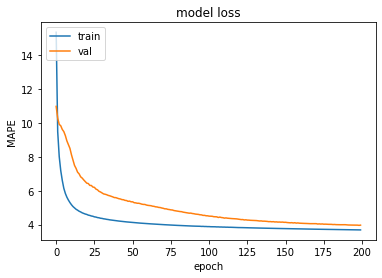

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('gru.jpeg')


MODEL LSTM

In [15]:
model_enc_LSTM = Sequential()
model_enc_LSTM.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_LSTM.add(RepeatVector(n_steps_out))
model_enc_LSTM.add(LSTM(32, activation='relu', return_sequences=True))
model_enc_LSTM.add(TimeDistributed(Dense(2)))
model_enc_LSTM.summary()

cp_lstm = ModelCheckpoint('model_lstm', save_best_only=True, monitor='val_loss')
model_enc_LSTM.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))
history2 = model_enc_LSTM.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_lstm,EarlyStopping(monitor='val_loss', patience=20)])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 2)            66        
 tributed)                                                       
                                                                 
Total params: 31,170
Trainable params: 31,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4219/4219 [===========================

4219/4219 [==============================] - 64s 15ms/step - loss: 4.2175 - val_loss: 5.5074
Epoch 33/200
4219/4219 [==============================] - 66s 16ms/step - loss: 4.2019 - val_loss: 5.4777
Epoch 34/200
4219/4219 [==============================] - 65s 15ms/step - loss: 4.1863 - val_loss: 5.4245
Epoch 35/200
4219/4219 [==============================] - 64s 15ms/step - loss: 4.1704 - val_loss: 5.4045
Epoch 36/200
4219/4219 [==============================] - 65s 15ms/step - loss: 4.1585 - val_loss: 5.3487
Epoch 37/200
4219/4219 [==============================] - 68s 16ms/step - loss: 4.1474 - val_loss: 5.2754
Epoch 38/200
4219/4219 [==============================] - 61s 14ms/step - loss: 4.1374 - val_loss: 5.2793
Epoch 39/200
4219/4219 [==============================] - 64s 15ms/step - loss: 4.1268 - val_loss: 5.1946
Epoch 40/200
4219/4219 [==============================] - 61s 15ms/step - loss: 4.1105 - val_loss: 5.1981
Epoch 41/200
4219/4219 [==============================] - 6

4219/4219 [==============================] - 65s 15ms/step - loss: 3.8545 - val_loss: 4.5507
Epoch 78/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8535 - val_loss: 4.5490
Epoch 79/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.8466 - val_loss: 4.5349
Epoch 80/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.8431 - val_loss: 4.5397
Epoch 81/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8402 - val_loss: 4.5083
Epoch 82/200
4219/4219 [==============================] - 61s 15ms/step - loss: 3.8345 - val_loss: 4.5270
Epoch 83/200
4219/4219 [==============================] - 61s 15ms/step - loss: 3.8309 - val_loss: 4.5217
Epoch 84/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.8266 - val_loss: 4.5193
Epoch 85/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.8226 - val_loss: 4.4993
Epoch 86/200
4219/4219 [==============================] - 6

4219/4219 [==============================] - 64s 15ms/step - loss: 3.6851 - val_loss: 4.2561
Epoch 129/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.6805 - val_loss: 4.2694
Epoch 130/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.6790 - val_loss: 4.2441
Epoch 131/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.6765 - val_loss: 4.2517
Epoch 132/200
4219/4219 [==============================] - 64s 15ms/step - loss: 3.6751 - val_loss: 4.2363
Epoch 133/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.6730 - val_loss: 4.2528
Epoch 134/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.6707 - val_loss: 4.2564
Epoch 135/200
4219/4219 [==============================] - 65s 15ms/step - loss: 3.6692 - val_loss: 4.2289
Epoch 136/200
4219/4219 [==============================] - 61s 14ms/step - loss: 3.6652 - val_loss: 4.2485
Epoch 137/200
4219/4219 [==========================

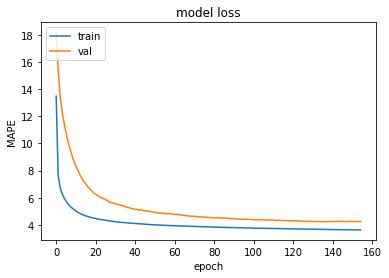

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('lstm.png')

MODEL BIDIRECTIONAL LSTM